In [145]:
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score, plot_roc_curve
from xgboost.sklearn import XGBClassifier
import seaborn as sns

In [146]:
ruta="C:/Users/Jose/Documents/Coding_Dojo/Project_2/Credit_Card_Defaulter_Prediction.csv"
df=pd.read_csv(ruta)

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         30000 non-null  int64 
 1   LIMIT_BAL  30000 non-null  int64 
 2   SEX        30000 non-null  object
 3   EDUCATION  30000 non-null  object
 4   MARRIAGE   30000 non-null  object
 5   AGE        30000 non-null  int64 
 6   PAY_0      30000 non-null  int64 
 7   PAY_2      30000 non-null  int64 
 8   PAY_3      30000 non-null  int64 
 9   PAY_4      30000 non-null  int64 
 10  PAY_5      30000 non-null  int64 
 11  PAY_6      30000 non-null  int64 
 12  BILL_AMT1  30000 non-null  int64 
 13  BILL_AMT2  30000 non-null  int64 
 14  BILL_AMT3  30000 non-null  int64 
 15  BILL_AMT4  30000 non-null  int64 
 16  BILL_AMT5  30000 non-null  int64 
 17  BILL_AMT6  30000 non-null  int64 
 18  PAY_AMT1   30000 non-null  int64 
 19  PAY_AMT2   30000 non-null  int64 
 20  PAY_AMT3   30000 non-null  i

In [148]:
#LIMPIEZA DE BASE DE DATOA
df.PAY_2=df.PAY_2.astype(str)
df.PAY_3=df.PAY_3.astype(str)
df.PAY_4=df.PAY_4.astype(str)
df.PAY_5=df.PAY_5.astype(str)
df.PAY_6=df.PAY_6.astype(str)
df.PAY_0=df.PAY_0.astype(str)
df['MARRIAGE']=np.where(df['MARRIAGE']=='0',"Other",df['MARRIAGE'])
df['default ']=np.where(df['default ']=='N',0,1)
df.EDUCATION=np.where(df.EDUCATION=='0',"Unknown",df.EDUCATION)
df.EDUCATION=np.where(df.EDUCATION=='Others',"Unknown",df.EDUCATION)
df=df.drop(columns="ID")

In [149]:
df1=df.loc[(df["default "]==1),:]
df2=df.loc[(df["default "]==0),:]

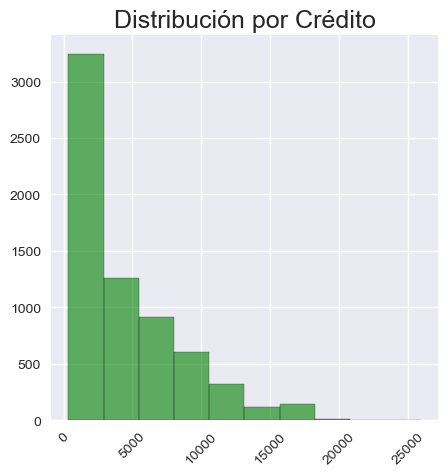

In [150]:
plt.style.use("seaborn")
plt.figure(figsize=(5,5))
ax=df1.LIMIT_BAL*0.035
ax.hist(edgecolor='black',label="Educación", color="green", alpha = .6);
plt.title('Distribución por Crédito', fontsize=18, )
plt.xticks(rotation=45);

In [151]:
len(df1)/len(df)

0.2212

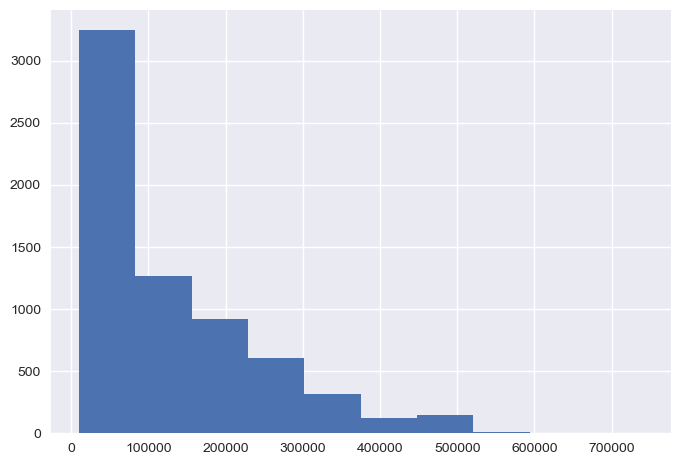

In [152]:
df1.LIMIT_BAL.hist(bins=10);


In [153]:
#X=df.drop(columns=["default ","PAY_2", "PAY_3","PAY_4", "PAY_5","PAY_6"])
X=df.drop(columns=["default "])
y=df['default '].values
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
X_ohe = ohe.fit_transform(X)
X=X_ohe

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=8, stratify=y)
scaler=StandardScaler()
scaler.fit(X_train)
X1_train=scaler.transform(X_train)
X1_test=scaler.transform(X_test)

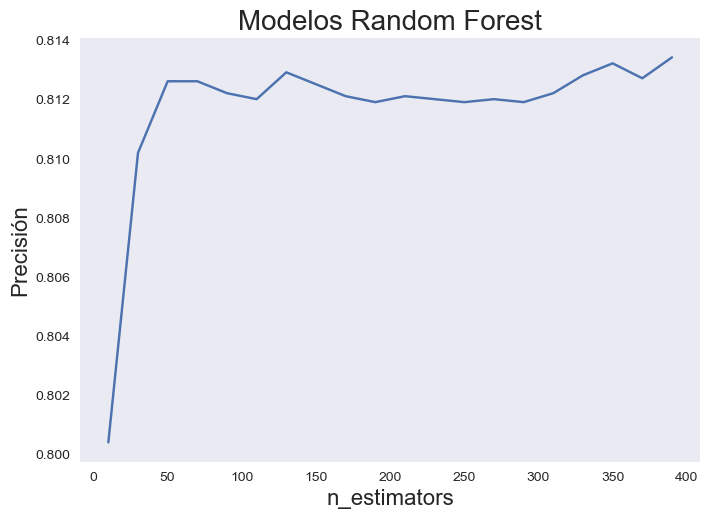

In [154]:
#Búsqueda del n_estimator para lograr el mejor score
estimator_range_forest = list(range(10, 400, 20))
scores_forest = []
#En Random Forest no es necesario utilizar datos escalados
for estimator in estimator_range_forest:
    forest = RandomForestClassifier(n_estimators=estimator, random_state=8, n_jobs=-1)
    forest.fit(X1_train, y_train)
    scores_forest.append(forest.score(X1_test, y_test))
#Gráfica de los distintos random forests con n_estimators variaando entre 10-300
#Se observa mejor resultado con n_estimators=160
plt.plot(estimator_range_forest, scores_forest)
plt.xlabel('n_estimators', fontsize =16)
plt.ylabel('Precisión', fontsize = 16)
plt.title('Modelos Random Forest', fontsize = 20)
plt.grid();

In [155]:
#De la gráfica anterior, se concluye que n_estimators para mejorprecisión es 60
forest = RandomForestClassifier(n_estimators=390, random_state=8, 
oob_score=True, n_jobs=-1)
forest.fit(X_train, y_train)
preds_forest=forest.predict(X_test)

#Parámetros de medición, R2, MAE & RMSE
forest_r2_train = forest.score(X_train,y_train)
forest_r2_test = forest.score(X_test,y_test)
forest_r2_test

0.8135353535353536

In [156]:
#Caracteristicas pricipales del modelo
forest_feature=pd.DataFrame({'feature':X_train.columns, 'feature_importance':forest.feature_importances_})
forest_feature=forest_feature.sort_values(by='feature_importance',ascending=False)
forest_feature[0:15]

,feature,feature_importance
10,AGE,0.062294
0,LIMIT_BAL,0.060531
75,BILL_AMT1,0.057016
11,PAY_0_2,0.054734
76,BILL_AMT2,0.052094
77,BILL_AMT3,0.049402
78,BILL_AMT4,0.048533
81,PAY_AMT1,0.047931
79,BILL_AMT5,0.047485
80,BILL_AMT6,0.047456


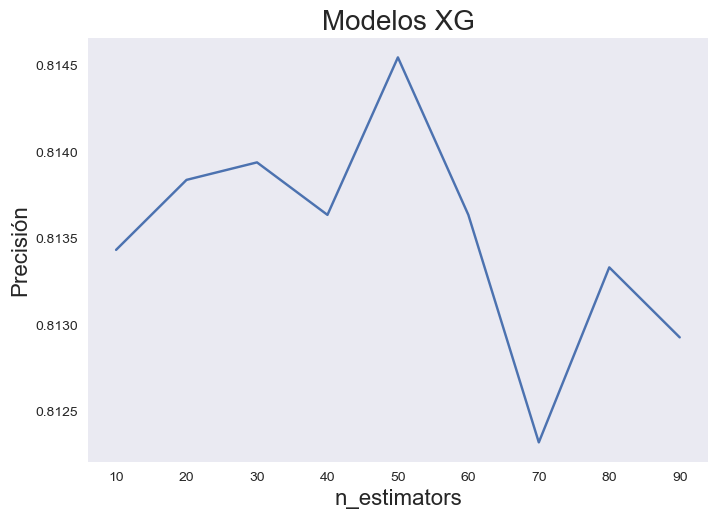

In [157]:
#Búsqueda del n_estimator para lograr el mejor score
estimator_range_forest = list(range(10, 100, 10))
scores_xg = []
#En Random Forest no es necesario utilizar datos escalados
for estimator in estimator_range_forest:
    xg = XGBClassifier(n_estimators=estimator, random_state=8, n_jobs=-1, objective='binary:logistic', eval_metric="error" , 
     use_label_encoder=False)
    xg.fit(X1_train, y_train)
    scores_xg.append(xg.score(X1_test, y_test))
#Gráfica de los distintos random forests con n_estimators variaando entre 10-300
#Se observa mejor resultado con n_estimators=160
plt.plot(estimator_range_forest, scores_xg)
plt.xlabel('n_estimators', fontsize =16)
plt.ylabel('Precisión', fontsize = 16)
plt.title('Modelos XG', fontsize = 20)
plt.grid();


In [158]:
#De la gráfica anterior, se concluye que n_estimators para mejor precisión es 50
xg = XGBClassifier(n_estimators=50, random_state=8, n_jobs=-1, objective='binary:logistic', eval_metric="error" , 
     use_label_encoder=False);
xg.fit(X1_train, y_train);
preds_xg=xg.predict(X1_test);

#Parámetros de medición, R2, MAE & RMSE
xg_train = xg.score(X1_train,y_train);
xg_test = xg.score(X1_test,y_test);
xg_test


0.8145454545454546

In [159]:
#MODELO XGBOOST
cm = metrics.confusion_matrix(y_test, preds_xg).ravel()
tn, fp, fn, tp = cm
precision = tp / (tp + fp)
sensitivity = tp/ (tp + fn)
specificity = tn / (tn + fp)
print("XGBOOST")
print('Orecisión: {:.3f}'.format(precision))
print('Sensibilidad: {:.3f}'.format(sensitivity))
print('Especificidad: {:.3f}'.format(specificity))

XGBOOST
Orecisión: 0.649
Sensibilidad: 0.352
Especificidad: 0.946


In [160]:
#MODELO XGBOOST
matriz=[[tn,fn],[fp,tp]]
precision=(tp+tn)/(tp+fp+tn+fn)
matriz

[[7293, 1419], [417, 771]]

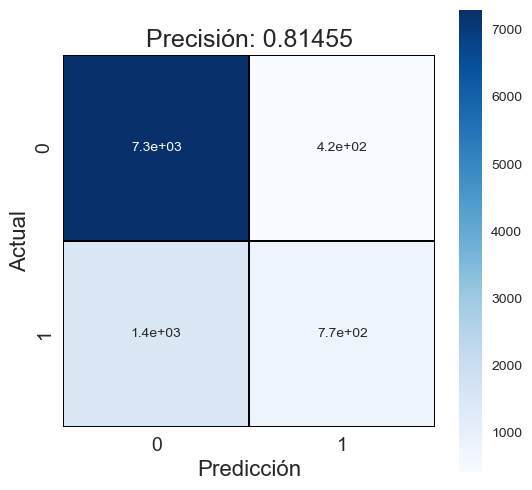

In [161]:
#MODELO XGBOOST
plt.figure(figsize=(6,6))
sns.heatmap(cm.reshape(2,2),annot=True, cmap="Blues", linecolor='black', linewidths=0.1, square=True );
plt.ylabel('Actual', fontsize=16)
plt.xlabel('Predicción', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Precisión: {:.5}'.format(precision),fontsize=18);

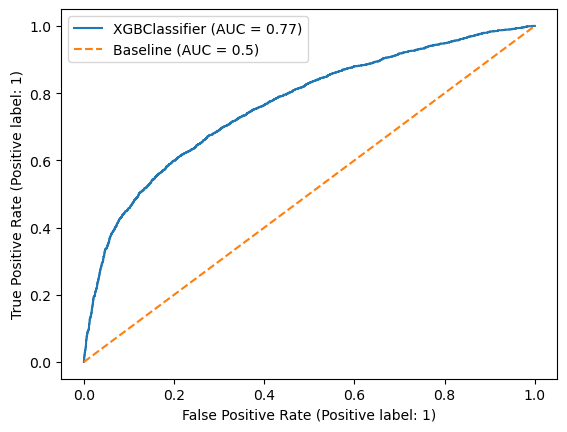

In [162]:
#MODELO XGBOOST
plt.style.use("default")
plot_roc_curve(xg, X1_test, y_test)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();